# ARIMA example
#### https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

In [131]:
import pandas as pd, numpy as np
from numpy import log
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
from dateutil.parser import parse

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.figsize': (9, 7),
                     'figure.dpi': 120})

#### Import data

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv',
                 names=['value'],
                 header=0)
print(df.shape)
df.head()

(100, 1)


,value
0,88
1,84
2,85
3,85
4,84


### Find the order of differencing (d) in ARIMA model

#### Check if the series is stationary using the Augmented Dickey Fuller test 
The null hypothesis of the ADF test is that the time series is non-stationary.  
So, if the p-value of the test is less than the significance level (0.05), then you reject the null hypothesis and infer that the time series is indeed stationary.  
So, in our case, if P Value > 0.05 we go ahead with finding the order of differencing.

In [4]:
result = adfuller(df.value.dropna())
print('ADF statistics: %f' % result[0])
print('p-value: %f' % result[1])

ADF statistics: -2.464240
p-value: 0.124419


#### Plot original series, 1st differencing, and 2nd differencing
The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.  

If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.  

In the event, you can’t really decide between two orders of differencing, then go with the order that gives the least standard deviation in the differenced series.  

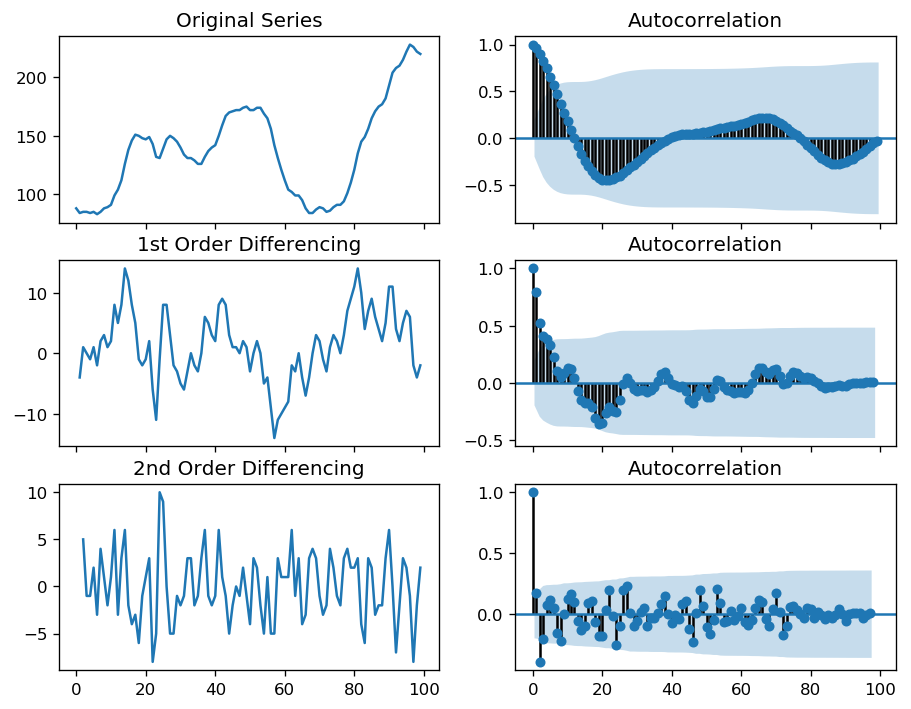

In [5]:
fig, axes = plt.subplots(3, 2, sharex=True)

# Original Series
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1], lags=99)

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1], lags=98)

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1], lags=97)

plt.show()

For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.  

So, I am going to tentatively fix the order of differencing as 1 even though the series is not perfectly stationary (weak stationarity).

In [9]:
y = df.value

# ADF test
print('adf:', ndiffs(y, test='adf'))

# KPSS test
print('kpss:', ndiffs(y, test='kpss'))

# PP test
print('pp:', ndiffs(y, test='pp'))

adf: 2
kpss: 0
pp: 2


### Find the order of the AR term (p)

#### PCAF plot of 1st differenced series
We initially take the order of AR term to be equal to as many lags that crosses the significance limit in the PACF plot.

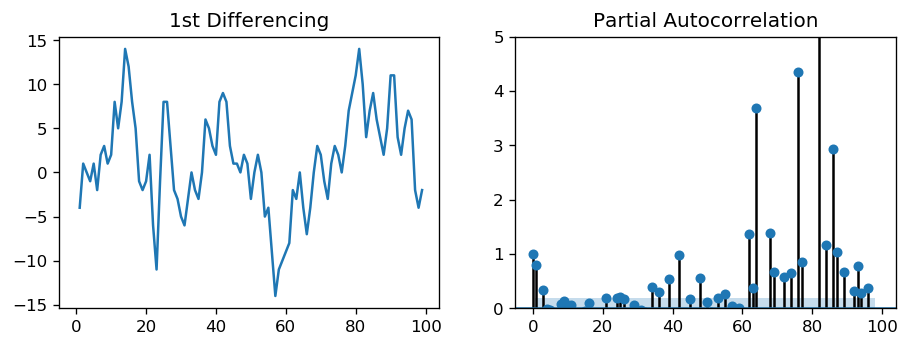

In [16]:
plt.rcParams.update({'figure.figsize': (9, 3),
                     'figure.dpi': 120})

fig, axes= plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0, 5))
plot_pacf(df.value.diff().dropna(), ax=axes[1], lags=100, alpha=0.05)

plt.show()

The PACF lag 1 is quite significant since is well above the significance line.  
Lag 2 turns out to be significant as well, slightly managing to cross the significance limit (blue region).  
But I am going to be conservative and tentatively fix the p as 1.

### Find the order of the MA term (q)

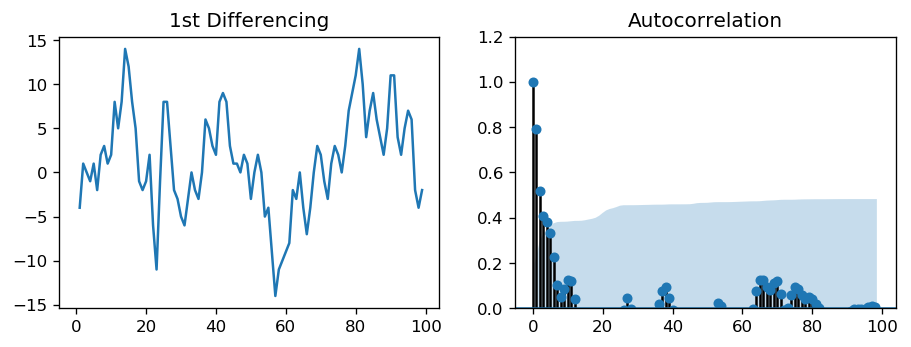

In [19]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0, 1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1], lags=98, alpha=0.05)

plt.show()

Couple of lags are well above the significance line. So, let’s tentatively fix q as 2.

If the series is slightly under differenced, adding one or more additional AR terms usually makes it up.  
Likewise, if it is slightly over-differenced, try adding an additional MA term.

### Build the ARIMA Model

In [22]:
# 1, 1, 2 ARIMA model
model = ARIMA(df.value, order=(1, 1, 2)) #order=(p,d,q)
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   99
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -253.790
Method:                       css-mle   S.D. of innovations              3.119
Date:                Thu, 19 Dec 2019   AIC                            517.579
Time:                        13:15:28   BIC                            530.555
Sample:                             1   HQIC                           522.829
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1202      1.290      0.868      0.387      -1.409       3.649
ar.L1.D.value     0.6351      0.257      2.469      0.015       0.131       1.139
ma.L1.D.value     0.5287      0.355     

In [24]:
# 1, 1, 1 ARIMA model
model = ARIMA(df.value, order=(1, 1, 1)) #order=(p,d,q)
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                   99
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -253.790
Method:                       css-mle   S.D. of innovations              3.119
Date:                Thu, 19 Dec 2019   AIC                            515.579
Time:                        13:17:42   BIC                            525.960
Sample:                             1   HQIC                           519.779
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.1205      1.286      0.871      0.386      -1.400       3.641
ar.L1.D.value     0.6344      0.087      7.317      0.000       0.464       0.804
ma.L1.D.value     0.5297      0.089     

####  Plot the residual errors to ensure there are no patterns (that is, look for constant mean and variance)

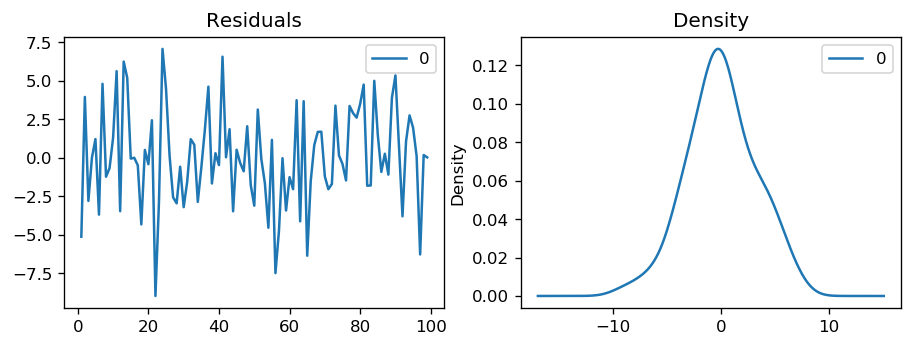

In [27]:
residuals = pd.DataFrame(model_fit.resid)
plt.rcParams.update({'figure.figsize': (9, 3),
                     'figure.dpi':120})
fig, ax = plt.subplots(1, 2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

The residual errors seem fine with near zero mean and uniform variance.

#### Plot the actuals against the fitted values

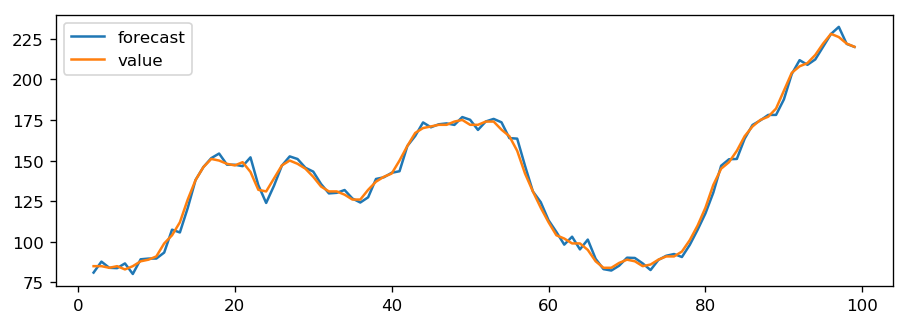

In [28]:
model_fit.plot_predict(dynamic=False) # When set dynamic=False, the in-sample lagged values are used for prediction.
plt.show()

### Find the optimal ARIMA model manually using Out-of-Time Cross validation
Take few steps back in time and forecast into the future to as many steps you took back. Then compare the forecast against the actuals.

#### Create train and test sets

In [30]:
train = df.value[:85]
test = df.value[85:]

#### Build model

In [31]:
model = ARIMA(train, order=(1, 1, 1))
fitted = model.fit(disp=-1)

#### Forecast

In [36]:
fc, se, conf = fitted.forecast(15, alpha=0.05)
print(fc)
print(se)
print(conf)

[163.32533063 168.39999392 172.0054823  174.65193294 176.67234963
 178.28410824 179.62910588 180.79996917 181.85716224 182.84015447
 183.77471038 184.67764838 185.55994706 186.42877294 187.28880415]
[ 3.17352139  7.49750763 11.83349925 15.95204169 19.78523198 23.32933367
 26.60544102 29.6425818  32.47040897 35.11622443 37.6039914  39.95424174
 42.18435717 44.30897723 46.34042044]
[[157.105343   169.54531825]
 [153.70514898 183.09483885]
 [148.81224996 195.19871464]
 [143.38650575 205.91736014]
 [137.89400751 215.45069174]
 [132.55945447 224.008762  ]
 [127.48339968 231.77481208]
 [122.70157644 238.8983619 ]
 [118.21633009 245.49799438]
 [114.01361932 251.66668961]
 [110.07224157 257.47717919]
 [106.36877354 262.98652322]
 [102.8801263  268.23976782]
 [ 99.58477338 273.2727725 ]
 [ 96.46324906 278.11435923]]


In [38]:
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

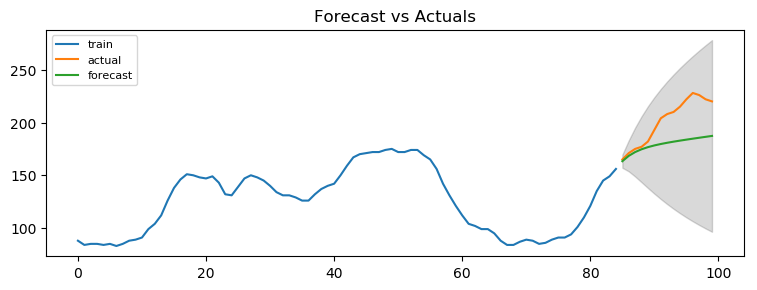

In [41]:
plt.figure(figsize=(9, 3), dpi=100)
plt.plot(train, label='train')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(test.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### Try another ARIMA model with different (p, d, q)

In [69]:
def run_model(train_size, p, d, q):
    train = df.value[:train_size]
    test = df.value[train_size:]
    
    model = ARIMA(train, order=(p, d, q))
    fitted = model.fit(disp=-1)
    print(fitted.summary())

    fc, se, conf = fitted.forecast(len(df.value) - train_size, alpha=0.05)

    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(conf[:, 0], index=test.index)
    upper_series = pd.Series(conf[:, 1], index=test.index)

    plt.figure(figsize=(9, 3), dpi=100)
    plt.plot(train, label='train')
    plt.plot(test, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(test.index, lower_series, upper_series,
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    return fc, test.values

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   83
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -214.248
Method:                       css-mle   S.D. of innovations              3.153
Date:                Thu, 19 Dec 2019   AIC                            440.497
Time:                        14:43:11   BIC                            455.010
Sample:                             2   HQIC                           446.327
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0483      0.084      0.577      0.565      -0.116       0.212
ar.L1.D2.value     1.1386      0.109     10.399      0.000       0.924       1.353
ar.L2.D2.value    -0.5923      0.155

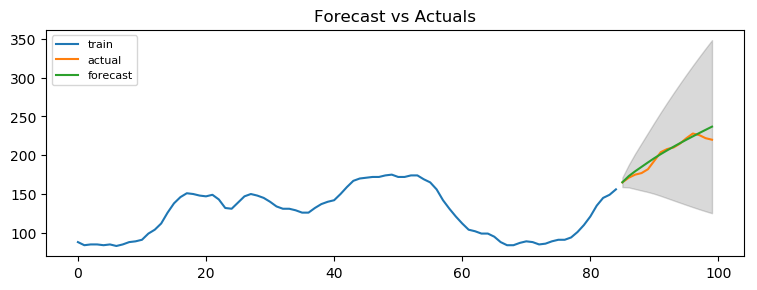

In [99]:
train_size = 85; p = 3; d = 2; q = 1
forecast, actual = run_model(train_size, p, d, q)

                             ARIMA Model Results                              
Dep. Variable:               D2.value   No. Observations:                   73
Model:                 ARIMA(3, 2, 1)   Log Likelihood                -188.772
Method:                       css-mle   S.D. of innovations              3.154
Date:                Thu, 19 Dec 2019   AIC                            389.544
Time:                        14:45:31   BIC                            403.287
Sample:                             2   HQIC                           395.021
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0454      0.072     -0.635      0.528      -0.186       0.095
ar.L1.D2.value     1.0835      0.117      9.233      0.000       0.854       1.314
ar.L2.D2.value    -0.5558      0.159

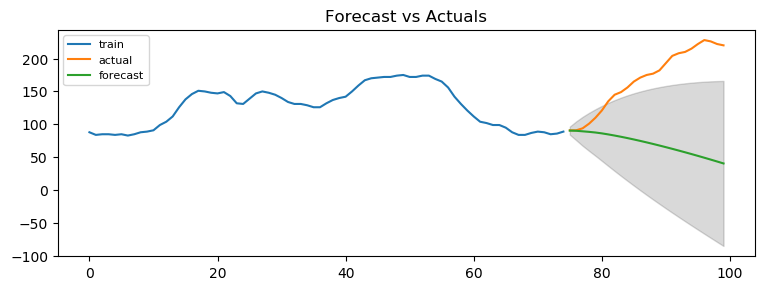

In [105]:
train_size = 75; p = 3; d = 2; q = 1
forecast, actual = run_model(train_size, p, d, q)

### Choose accuracy metrics for time series forecast
If comparing forecasts of two different series, the MAPE, Correlation and Min-Max Error can be used.  
Because only the above three are percentage errors that vary between 0 and 1. That way, you can judge how good is the forecast irrespective of the scale of the series.

In [103]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual)) # MAPE
    me = np.mean(forecast- actual) # ME
    mae = np.mean(np.abs(forecast - actual)) # MAE
    mpe = np.mean((forecast - actual) / actual) # MPE
    rmse = np.mean((forecast - actual) ** 2) ** .5 # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1] # corr
    mins = np.amin(np.hstack([forecast[:, None],
                              actual[:, None]]),
                   axis=1)
    maxs = np.amax(np.hstack([forecast[:, None],
                              actual[:, None]]),
                   axis=1)
    minmax = 1 - np.mean(mins / maxs) # minmax
    acf1 = acf(forecast - actual)[1] # acf1
    return ({'mape': mape,
             'me': me,
             'mae': mae,
             'mpe': mpe,
             'rmse': rmse,
             'acf1': acf1,
             'corr': corr,
             'minmax': minmax})

In [104]:
train_size = 85; p = 3; d = 2; q = 1
forecast_accuracy(forecast, actual)

{'mape': 0.022501320639815293,
 'me': 3.230787446595288,
 'mae': 4.548323646576828,
 'mpe': 0.01642102225925985,
 'rmse': 6.373241132743812,
 'acf1': 0.5105505497543064,
 'corr': 0.9674576522618462,
 'minmax': 0.021631554023586075}

Around 2.2% MAPE implies the model is about 97.8% accurate in predicting the next 15 observations.

In [106]:
train_size = 75; p = 3; d = 2; q = 1
forecast_accuracy(forecast, actual)

{'mape': 0.5131417285102292,
 'me': -98.17242779360427,
 'mae': 98.17242779360427,
 'mpe': -0.5131417285102292,
 'rmse': 115.67591559501403,
 'acf1': 0.9042593486332237,
 'corr': -0.9518469103409158,
 'minmax': 0.5131417285102293}

Around 51.3% MAPE implies the model is about 48.7% accurate in predicting the next 25 observations.

### Auto ARIMA forecast
auto_arima() uses a stepwise approach to search multiple combinations of (p, d, q) parameters and chooses the best model that has the least AIC.

In [113]:
model = pm.auto_arima(df.value,
                      start_p=1, max_p=3,
                      start_q=1, max_q=3,
                      test='adf', # use adftest to find optimal 'd'
                      m=1, # frequency of series
                      d=None, # let model determine 'd'
                      seasonal=False, # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warning=True,
                      stepwise=True)
print(model.summary())

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 0, 0, 0); AIC=525.587, BIC=535.926, Fit time=0.052 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 0); AIC=533.474, BIC=538.644, Fit time=0.008 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 0, 0, 0); AIC=532.437, BIC=540.192, Fit time=0.019 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 0, 0); AIC=525.893, BIC=533.648, Fit time=0.025 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 0); AIC=531.477, BIC=534.062, Fit time=0.007 seconds
Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 0, 0, 0); AIC=515.248, BIC=528.173, Fit time=0.043 seconds
Fit ARIMA: order=(2, 2, 0) seasonal_order=(0, 0, 0, 0); AIC=513.459, BIC=523.799, Fit time=0.038 seconds
Fit ARIMA: order=(3, 2, 0) seasonal_order=(0, 0, 0, 0); AIC=515.284, BIC=528.209, Fit time=0.037 seconds
Fit ARIMA: order=(3, 2, 1) seasonal_order=(0, 0, 0, 0); AIC=512.556, BIC=528.066, Fit time=0.244 seconds
Near non-invertible roots for order (3, 2, 1)(0, 0, 0, 

C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


### Interpret the residual plots in ARIMA model

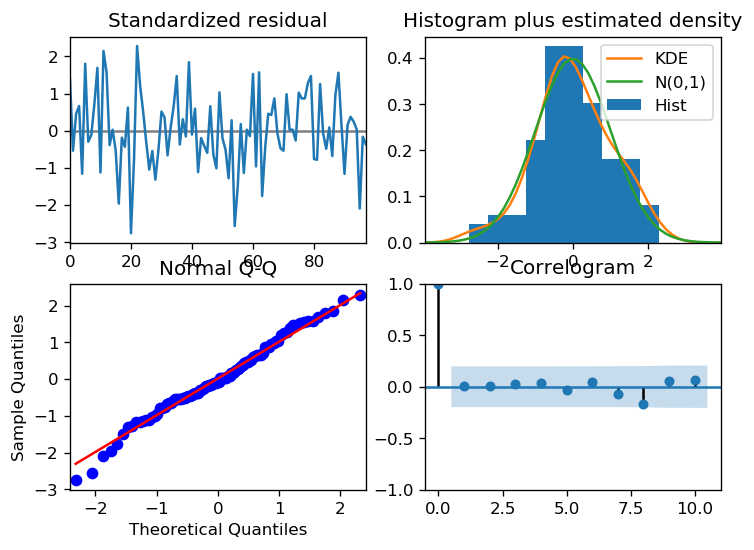

In [114]:
model.plot_diagnostics(figsize=(7, 5))
plt.show()

Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.  

Top Right: The density plot suggest normal distribution with mean zero.  

Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.  

Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.  

#### Final forecast

In [118]:
def final_forecast(n_periods):
    fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = np.arange(len(df.value), len(df.value) + n_periods)

    fc_series = pd.Series(fc, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    plt.figure(figsize=(9, 3), dpi=100)
    plt.plot(df.value)
    plt.plot(fc_series, color='darkgreen')
    plt.fill_between(index_of_fc, lower_series, upper_series,
                     color='k', alpha=.15)
    
    plt.title('Final Forecast of WWW Usage')
    plt.show()

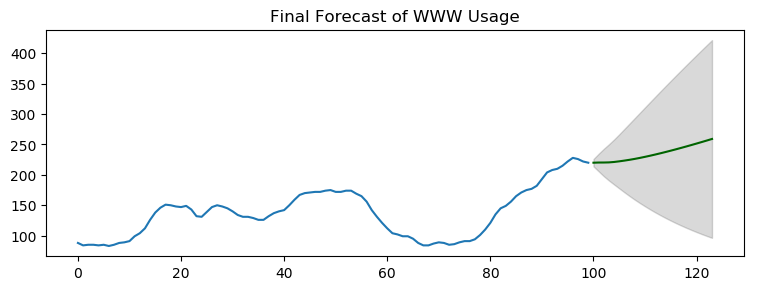

In [119]:
n_periods = 24
final_forecast(n_periods)

### Automatically build SARIMA model
Seasonal differencing is similar to regular differencing, but, instead of subtracting consecutive terms, you subtract the value from previous season.  

The model will be represented as SARIMA(p,d,q)x(P,D,Q), where, P, D and Q are SAR, order of seasonal differencing and SMA terms respectively and 'x' is the frequency of the time series.  

As a general rule, set the model parameters such that D never exceeds one. And the total differencing ‘d + D’ never exceeds 2. Try to keep only either SAR or SMA terms if your model has seasonal components.

#### Import the drug sales dataset

In [122]:
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv',
                   parse_dates=['date'],
                   index_col='date')
print(data.shape)
data.head()

(204, 1)


,value
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869


#### Plot the data

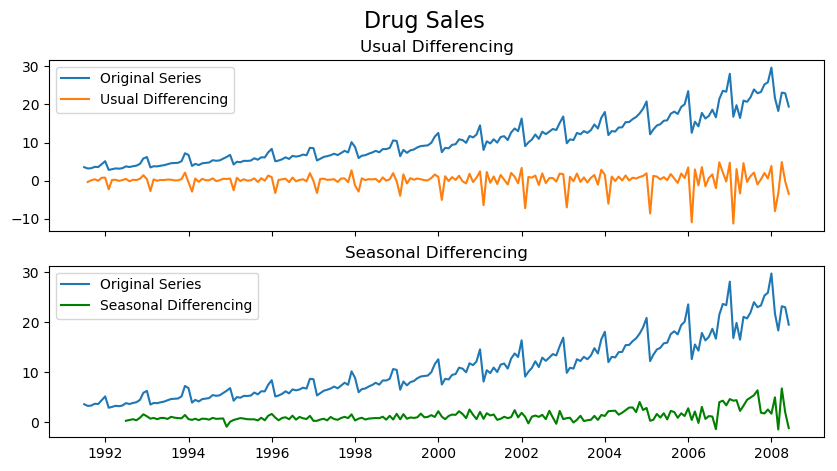

In [124]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5), dpi=100, sharex=True)

# Usual differencing
axes[0].plot(data[:], label='Original Series')
axes[0].plot(data[:].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)

# Seasonal differencing
axes[1].plot(data[:], label='Original Series')
axes[1].plot(data[:].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
axes[1].legend(loc='upper left', fontsize=10)

plt.suptitle('Drug Sales', fontsize=16)
plt.show()

####  Build the SARIMA model
Seasonal - fit stepwise auto-ARIMA

In [126]:
smodel = pm.auto_arima(data,
                       start_p=1, max_p=3,
                       start_q=1, max_q=3,
                       test='adf', # use adftest to find optimal 'd'
                       m=12, # frequency of series
                       d=None, # let model determine 'd'
                       seasonal=True, # No Seasonality
                       start_P=0, 
                       D=1, # enforce D=1
                       trace=True,
                       error_action='ignore',
                       suppress_warning=True,
                       stepwise=True)
print(smodel.summary())

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=534.818, BIC=551.105, Fit time=0.829 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=624.061, BIC=630.576, Fit time=0.014 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=596.068, BIC=609.098, Fit time=0.326 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=611.475, BIC=624.505, Fit time=0.237 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=757.274, BIC=760.532, Fit time=0.014 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 0, 12); AIC=559.407, BIC=572.437, Fit time=0.152 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=554.763, BIC=574.308, Fit time=1.387 seconds
Near non-invertible roots for order (1, 0, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 2, 12); AIC=536.817, BIC=556.362, Fit time=3.210 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 0, 12); AIC=543.106, BIC=559.393, Fit time=0.900 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 2, 12); AIC=537.777, BIC=560.580, Fit time=3.816 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 1, 12); AIC=594.467, BIC=607.497, Fit time=0.248 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=529.829, BIC=549.374, Fit time=0.941 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 1, 0, 12); AIC=555.198, BIC=571.485, Fit time=0.197 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=552.240, BIC=575.043, Fit time=1.662 seconds
Near non-invertible roots for order (2, 0, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 1, 2, 12); AIC=531.168, BIC=553.970, Fit time=2.572 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(1, 1, 0, 12); AIC=534.757, BIC=554.302, Fit time=0.836 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 1) seasonal_order=(1, 1, 2, 12); AIC=524.323, BIC=550.383, Fit time=4.443 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: order=(2, 0, 1) seasonal_order=(2, 1, 2, 12); AIC=533.034, BIC=562.352, Fit time=5.089 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 1) seasonal_order=(2, 1, 1, 12); AIC=531.889, BIC=557.949, Fit time=5.003 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: order=(2, 0, 0) seasonal_order=(1, 1, 2, 12); AIC=545.610, BIC=568.413, Fit time=3.387 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: order=(3, 0, 1) seasonal_order=(1, 1, 2, 12); AIC=518.184, BIC=547.501, Fit time=4.903 seconds
Near non-invertible roots for order (3, 0, 1)(1, 1, 2, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.992)


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 1, 2, 12); AIC=524.665, BIC=553.982, Fit time=6.498 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 2, 12); AIC=593.876, BIC=613.421, Fit time=2.327 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 2) seasonal_order=(1, 1, 2, 12); AIC=524.083, BIC=550.143, Fit time=5.608 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 3) seasonal_order=(1, 1, 2, 12); AIC=527.321, BIC=559.896, Fit time=5.914 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 1, 2, 12); AIC=532.804, BIC=555.607, Fit time=3.682 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: order=(1, 0, 2) seasonal_order=(1, 1, 1, 12); AIC=552.766, BIC=575.568, Fit time=2.337 seconds
Near non-invertible roots for order (1, 0, 2)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(1, 0, 2) seasonal_order=(2, 1, 2, 12); AIC=534.472, BIC=563.789, Fit time=5.453 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 1, 1, 12); AIC=531.170, BIC=550.715, Fit time=1.184 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Fit ARIMA: order=(1, 0, 2) seasonal_order=(2, 1, 1, 12); AIC=532.815, BIC=558.875, Fit time=4.274 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: order=(0, 0, 2) seasonal_order=(1, 1, 2, 12); AIC=583.617, BIC=606.420, Fit time=2.761 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 3) seasonal_order=(1, 1, 2, 12); AIC=519.565, BIC=548.882, Fit time=6.002 seconds
Near non-invertible roots for order (1, 0, 3)(1, 1, 2, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.992)


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 1, 2, 12); AIC=614.924, BIC=634.469, Fit time=2.258 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: order=(0, 0, 3) seasonal_order=(1, 1, 2, 12); AIC=566.118, BIC=592.178, Fit time=3.681 seconds
Total fit time: 92.174 seconds
                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(3, 0, 1)x(1, 1, 2, 12)   Log Likelihood                -250.092
Date:                            Thu, 19 Dec 2019   AIC                            518.184
Time:                                    15:38:43   BIC                            547.501
Sample:                                         0   HQIC                           530.058
                                            - 204                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------

#### Forecast for the next 24 months

In [129]:
def final_sforecast(n_periods):
    fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(data.index[-1], periods=n_periods, freq='MS')

    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    plt.figure(figsize=(9, 3), dpi=100)
    plt.plot(data)
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(index_of_fc, 
                     lower_series, 
                     upper_series, 
                     color='k', alpha=.15)

    plt.title("SARIMA - Final Forecast of a10 - Drug Sales")
    plt.show()

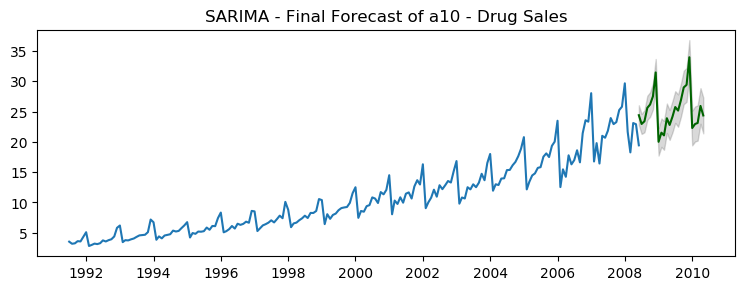

In [130]:
n_periods = 24
final_sforecast(n_periods)

### Build SARIMAX Model with exogenous variable
The only requirement to use an exogenous variable is you need to know the value of the variable during the forecast period as well.

#### Multiplicative seasonal component

In [144]:
result_mul = seasonal_decompose(data['value'][-36: ], # 3 years
                                model='multiplicative',
                                extrapolate_trend='freq')
seasonal_index = result_mul.seasonal[-12: ].to_frame()
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month

In [145]:
seasonal_index

,value,month
date,,
2007-07-01,0.970490,7
2007-08-01,1.050900,8
2007-09-01,0.998881,9
2007-10-01,1.059657,10
2007-11-01,1.146141,11
2007-12-01,1.150750,12
2008-01-01,1.316913,1
2008-02-01,0.803279,2
2008-03-01,0.850667,3


#### Merge with the base data

In [151]:
data['month'] = data.index.month
df = pd.merge(data, seasonal_index, how='left', on='month')
df.columns = ['value', 'month', 'seasonal_index']
df.index = data.index
df.head()

,value,month,seasonal_index
date,,,
1991-07-01,3.526591,7,0.970490
1991-08-01,3.180891,8,1.050900
1991-09-01,3.252221,9,0.998881
1991-10-01,3.611003,10,1.059657
1991-11-01,3.565869,11,1.146141


#### Build SARIMAX model

In [152]:
sxmodel = pm.auto_arima(df[['value']],
                        exogenous=df[['seasonal_index']],
                        start_p=1, max_p=3,
                        start_q=1, max_q=3,
                        test='adf', # use adftest to find optimal 'd'
                        m=12, # frequency of series
                        d=None, # let model determine 'd'
                        seasonal=True, # No Seasonality
                        start_P=0, 
                        D=1, # enforce D=1
                        trace=True,
                        error_action='ignore',
                        suppress_warning=True,
                        stepwise=True)
print(sxmodel.summary())

C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=536.818, BIC=556.362, Fit time=1.017 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=626.061, BIC=635.834, Fit time=0.020 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=598.068, BIC=614.356, Fit time=0.398 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=613.475, BIC=629.762, Fit time=0.292 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=759.274, BIC=765.789, Fit time=0.072 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 0, 12); AIC=561.407, BIC=577.695, Fit time=0.190 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=556.698, BIC=579.501, Fit time=1.759 seconds
Near non-invertible roots for order (1, 0, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 2, 12); AIC=538.817, BIC=561.620, Fit time=3.289 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 0, 12); AIC=545.106, BIC=564.651, Fit time=1.126 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 2, 12); AIC=539.560, BIC=565.619, Fit time=4.440 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 1, 12); AIC=596.467, BIC=612.754, Fit time=0.285 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=531.829, BIC=554.632, Fit time=1.254 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 1, 0, 12); AIC=557.198, BIC=576.743, Fit time=0.233 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=554.240, BIC=580.300, Fit time=2.097 seconds
Near non-invertible roots for order (2, 0, 1)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 1, 2, 12); AIC=533.168, BIC=559.228, Fit time=2.866 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(2, 0, 1) seasonal_order=(1, 1, 0, 12); AIC=536.757, BIC=559.560, Fit time=1.040 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 1) seasonal_order=(1, 1, 2, 12); AIC=526.112, BIC=555.430, Fit time=5.204 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: order=(2, 0, 1) seasonal_order=(2, 1, 2, 12); AIC=535.034, BIC=567.609, Fit time=5.155 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 1) seasonal_order=(2, 1, 1, 12); AIC=533.776, BIC=563.094, Fit time=5.365 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: order=(2, 0, 0) seasonal_order=(1, 1, 2, 12); AIC=547.610, BIC=573.670, Fit time=4.172 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(3, 0, 1) seasonal_order=(1, 1, 2, 12); AIC=520.184, BIC=552.759, Fit time=5.657 seconds
Near non-invertible roots for order (3, 0, 1)(1, 1, 2, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.992)


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 1, 2, 12); AIC=530.769, BIC=563.344, Fit time=6.936 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 2, 12); AIC=595.876, BIC=618.678, Fit time=2.672 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 2) seasonal_order=(1, 1, 2, 12); AIC=525.909, BIC=555.226, Fit time=5.832 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 0, 3) seasonal_order=(1, 1, 2, 12); AIC=529.038, BIC=564.871, Fit time=6.162 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 1, 2, 12); AIC=534.804, BIC=560.864, Fit time=3.279 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages

Fit ARIMA: order=(1, 0, 2) seasonal_order=(1, 1, 1, 12); AIC=554.768, BIC=580.828, Fit time=2.354 seconds
Near non-invertible roots for order (1, 0, 2)(1, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(1, 0, 2) seasonal_order=(2, 1, 2, 12); AIC=536.472, BIC=569.047, Fit time=5.258 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 1, 1, 12); AIC=533.170, BIC=555.973, Fit time=1.479 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Fit ARIMA: order=(1, 0, 2) seasonal_order=(2, 1, 1, 12); AIC=534.815, BIC=564.132, Fit time=4.116 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: order=(0, 0, 2) seasonal_order=(1, 1, 2, 12); AIC=585.617, BIC=611.677, Fit time=2.758 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 0, 3) seasonal_order=(1, 1, 2, 12); AIC=521.576, BIC=554.151, Fit time=5.569 seconds
Near non-invertible roots for order (1, 0, 3)(1, 1, 2, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.992)


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 1, 2, 12); AIC=616.924, BIC=639.727, Fit time=2.225 seconds


C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\wshi\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:993: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Fit ARIMA: order=(0, 0, 3) seasonal_order=(1, 1, 2, 12); AIC=568.118, BIC=597.436, Fit time=3.721 seconds
Total fit time: 98.342 seconds
                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  204
Model:             SARIMAX(3, 0, 1)x(1, 1, 2, 12)   Log Likelihood                -250.092
Date:                            Fri, 20 Dec 2019   AIC                            520.184
Time:                                    09:53:14   BIC                            552.759
Sample:                                07-01-1991   HQIC                           533.377
                                     - 06-01-2008                                         
Covariance Type:                              opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------

#### Forecast

In [161]:
def final_sxforecast(n_periods):
    fitted, confint = smodel.predict(n_periods=n_periods,
                                     exogenous=np.tile(seasonal_index.value, int(n_periods/12)).reshape(-1,1),
                                     return_conf_int=True)
    index_of_fc = pd.date_range(data.index[-1], periods=n_periods, freq='MS')

    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    plt.figure(figsize=(9, 3), dpi=100)
    plt.plot(data['value'])
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(index_of_fc, 
                     lower_series, 
                     upper_series, 
                     color='k', alpha=.15)

    plt.title("SARIMAX - Final Forecast of a10 - Drug Sales")
    plt.show()

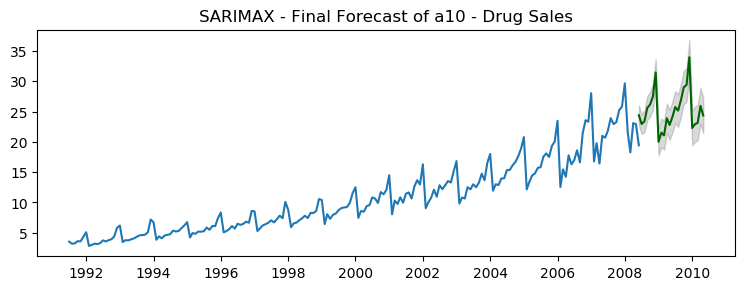

In [162]:
n_periods = 24
final_sxforecast(n_periods)